In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

from pathlib import Path
from tqdm import tqdm
import gc
from pandas.api.types import is_categorical_dtype, is_numeric_dtype

# Data

In [ ]:
from nn4tab.data import DataLoader, TabularDataset, get_dsets, cont_cat_split

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [ ]:
df = pd.read_csv('datasets//adult.csv')

In [ ]:
tmp = df[['education', 'education-num']].groupby('education', as_index=False).agg('mean')

In [ ]:
mgd = df[['education', 'education-num']].merge(tmp, how='left', on='education')
(mgd['education-num_x'] - mgd['education-num_y']).sum()

0.0

In [ ]:
df['education-num'] = mgd['education-num_y']

In [ ]:
del tmp, mgd
gc.collect()

0

In [ ]:
def normalize_numeric_cols(df):
    for col in df.columns:
        if is_numeric_dtype(df[col]):
            df[col] = ((df[col]-df[col].mean())/df[col].std()).astype(np.float32)

In [ ]:
normalize_numeric_cols(df)

In [ ]:
def categorify(df):
    for col in df.columns:
        if not is_numeric_dtype(df[col]):
            df[col] = df[col].astype('category')

In [ ]:
categorify(df)

In [ ]:
df.isna().any()

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
salary            False
dtype: bool

In [ ]:
df.occupation.cat.add_categories('#na', inplace=True)
df['occupation'] = df.occupation.fillna('#na')

In [ ]:
def fillna_cat(df):
    pass

In [ ]:
def numericalize_cat_cols(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes

In [ ]:
numericalize_cat_cols(df)

In [ ]:
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,0.763785,4,-0.838071,7,0.746028,2,15,5,4,0,-0.145918,4.503413,-0.035429,39,1
1,0.397227,4,0.444980,12,1.523415,0,4,1,4,1,1.278535,-0.216656,0.369514,39,1
2,-0.042641,4,-0.886721,11,-0.420053,0,15,4,2,0,-0.145918,-0.216656,-0.683337,39,0
3,-0.042641,5,-0.728862,14,1.912109,2,10,0,1,1,-0.145918,-0.216656,-0.035429,39,1
4,0.250604,6,-1.018298,5,-2.363521,2,8,5,2,0,-0.145918,-0.216656,0.774456,39,0


In [ ]:
dep_var = 'salary'
cont, cat = cont_cat_split(df, dep_var)

In [ ]:
cont, cat

(['age',
  'fnlwgt',
  'education-num',
  'capital-gain',
  'capital-loss',
  'hours-per-week'],
 ['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country'])

In [ ]:
train_ds, valid_ds = get_dsets(df, cat, cont, [dep_var])

In [ ]:
train_ds[0]

(array([ 6, 11,  2,  3,  0,  4,  1, 39]),
 array([ 1.790145  ,  2.0347579 , -0.42005318, -0.14591825, -0.2166562 ,
        -0.84531415], dtype=float32),
 array([0.], dtype=float32))

In [ ]:
_[0].dtype

dtype('int32')

In [ ]:
from nn4tab.data import get_dl

In [ ]:
train_dl = get_dl(train_ds)
valid_dl = get_dl(valid_ds, train=False)

In [ ]:
x_cat, x_cont, y = next(iter(train_dl))

x_cat.shape, x_cont.shape, y.shape

(torch.Size([512, 8]), torch.Size([512, 6]), torch.Size([512, 1]))

# Model

In [ ]:
from nn4tab.model import TabularModel, get_tabular_model

In [ ]:
model = get_tabular_model(df, cont, cat, 1, [100, 50])

In [ ]:
x_cat = x_cat.type(torch.long)

In [ ]:
pred = model(x_cat, x_cont)

In [ ]:
pred.shape

torch.Size([512, 1])

In [ ]:
nn.BCEWithLogitsLoss()(pred, y)

tensor(0.7925, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

# Training

In [ ]:
from nn4tab.learner import LearnerV0, accuracy_binary

In [ ]:
# def accuracy_binary(pred, targ):
#     return ((pred>0).float() == targ).float().mean()

In [ ]:
def get_dataloaders():
    return get_dl(train_ds), get_dl(valid_ds)

In [ ]:
dataloaders = get_dataloaders()
tab_nn = get_tabular_model(df, cont, cat, 1, [100, 50])

In [ ]:
learn = LearnerV0(tab_nn, dataloaders, torch.optim.Adam, nn.BCEWithLogitsLoss(), metrics=accuracy_binary)

In [ ]:
learn.fit(2)

epoch 2: valid loss 0.3175, accuracy 0.8519: 100%|█████████████████████| 12/12 [00:11<00:00,  1.04it/s]


In [ ]:
def plot_losses(learn):
    fig, ax = plt.subplots(figsize=(8,5))
    plt.plot(learn.train_losses.values)
    xvl = [(i+1)*len(learn.train_dl) for i in range(learn.epoch+1)]
    plt.plot(xvl, learn.valid_losses.avgs)
    ax.set_xlabel('Batches')
    ax.set_ylabel('Loss')
    plt.legend(['Train loss', 'Validation loss'])
    return ax

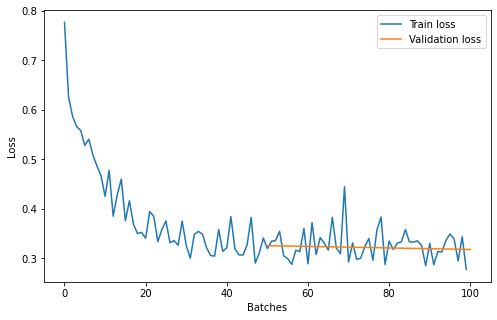

In [ ]:
plot_losses(learn);